In [ ]:
# Importing dependencies
!pip install optuna
!pip install catboost
!pip install shap
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelBinarizer, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from scipy import stats
from sklearn.feature_selection import mutual_info_classif

import optuna
import catboost
from catboost import CatBoostClassifier, Pool

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from matplotlib.gridspec import GridSpec

import shap

shap.initjs()

SEED = 10

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 5.3 MB/s eta 0:00:00


Reading Data

In [42]:
data = pd.read_csv('Weather_Data.csv')

data.head()

,Date,Temp9am,Temp3pm,MinTemp,MaxTemp,Rainfall,RainToday,Evaporation,Sunshine,WindGustDir,...,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm
0,01-02-13,20.7,20.9,19.5,22.4,15.6,Yes,6.2,0.0,W,...,S,SSW,17,20,92,84,1017.6,1017.4,8,8
1,02-02-13,22.4,24.8,19.5,25.6,6.0,Yes,3.4,2.7,W,...,W,E,9,13,83,73,1017.9,1016.4,7,7
2,03-02-13,23.5,23.0,21.6,24.5,6.6,Yes,2.4,0.1,W,...,ESE,ESE,17,2,88,86,1016.7,1015.6,7,8
3,04-02-13,21.4,20.9,20.2,22.8,18.8,Yes,2.2,0.0,W,...,NNE,E,22,20,83,90,1014.2,1011.8,8,8
4,05-02-13,22.5,25.5,19.7,25.7,77.4,Yes,4.8,0.0,W,...,NNE,W,11,6,88,74,1008.3,1004.8,8,8


Preprocessing

In [ ]:
# Encoding 3 categorical features for feature selection stage

lb1 = LabelEncoder()
data['WindGustDir'] = lb1.fit_transform(data['WindGustDir'])

lb2 = LabelEncoder()
data['WindDir9am'] = lb2.fit_transform(data['WindDir9am'])

lb3 = LabelEncoder()
data['WindDir3pm'] = lb3.fit_transform(data['WindDir3pm'])

Feature Extraction (Cyclical Feature)

In [ ]:
# Creating cyclical time features

def creata_new_feature(df):
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter

    return df

data_new = creata_new_feature(data)

data_new['day_sin'] = np.sin(data_new['dayofweek']*(2.*np.pi/30))
data_new['day_cos'] = np.cos(data_new['dayofweek']*(2.*np.pi/30))

data_new['month_sin'] = np.sin(data_new['month']*(2.*np.pi/12))
data_new['month_cos'] = np.cos(data_new['month']*(2.*np.pi/12))

data_new['quarter_sin'] = np.sin(data_new['quarter']*(2.*np.pi/4))
data_new['quarter_cos'] = np.sin(data_new['quarter']*(2.*np.pi/4))

data_new.drop(['dayofweek', 'month', 'quarter'], axis = 1, inplace = True)

In [ ]:
# Encoding target feature

lb = LabelBinarizer()
data_new['RainToday'] = lb.fit_transform(data_new['RainToday'])

data_new.head()

,Temp9am,Temp3pm,MinTemp,MaxTemp,Rainfall,RainToday,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,day_sin,day_cos,month_sin,month_cos,quarter_sin,quarter_cos
Date,,,,,,,,,,,,,,,,,,,,,
2013-01-02,20.7,20.9,19.5,22.4,15.6,1,6.2,0.0,13,41,...,1017.6,1017.4,8,8,0.406737,0.913545,0.500000,8.660254e-01,1.000000e+00,1.000000e+00
2013-02-02,22.4,24.8,19.5,25.6,6.0,1,3.4,2.7,13,41,...,1017.9,1016.4,7,7,0.866025,0.500000,0.866025,5.000000e-01,1.000000e+00,1.000000e+00
2013-03-02,23.5,23.0,21.6,24.5,6.6,1,2.4,0.1,13,41,...,1016.7,1015.6,7,8,0.866025,0.500000,1.000000,6.123234e-17,1.000000e+00,1.000000e+00
2013-04-02,21.4,20.9,20.2,22.8,18.8,1,2.2,0.0,13,41,...,1014.2,1011.8,8,8,0.207912,0.978148,0.866025,-5.000000e-01,1.224647e-16,1.224647e-16
2013-05-02,22.5,25.5,19.7,25.7,77.4,1,4.8,0.0,13,41,...,1008.3,1004.8,8,8,0.587785,0.809017,0.500000,-8.660254e-01,1.224647e-16,1.224647e-16


Feature Importance
It is an overt fact that the Rainfall feature is very highly correlated with the target variable in respect of Mutual Information score and Point-BiSerial Coefficient. This situation can give rise to an overfitting problem. For example, I used the Rainfall feature in training, model metrics quickly increased and to be 100 % in my trial with a CatBoostModel. This problem in machine learning is the target leakage. This is why I dropped the Rainfall feature.

In [ ]:
# Mutual inf for linear relationship, Point-BiSerial for nonlinear relationship
y = data_new.pop('RainToday')
X = data_new

point_biserial_coefs = []

for i in range(X.shape[1]):
    coef = stats.pointbiserialr(X.iloc[:,i], y)[0]
    point_biserial_coefs.append(coef)


mutual_inf = mutual_info_classif(X,y)


feature_importance = pd.DataFrame({'Mutual Inf':mutual_inf, 'Point-BiSerial':point_biserial_coefs}, index = X.columns )
feature_importance.sort_values(by = 'Point-BiSerial', ascending = False)

,Mutual Inf,Point-BiSerial
Humidity3pm,0.137657,0.477580
Cloud3pm,0.108703,0.415801
Cloud9am,0.072531,0.338545
Humidity9am,0.066021,0.335966
Rainfall,0.052962,0.296120
WindGustSpeed,0.007794,0.145382
WindDir3pm,0.050311,0.100092
MinTemp,0.000000,0.082804
WindSpeed9am,0.001436,0.065510
month_cos,0.000000,0.012797


In [ ]:
# Dropping the most correlated feature
X.drop(['Rainfall'], axis = 1, inplace = True)

Creating Train, Test Set

In [ ]:
X_train, X_test, y_train, y_test  = train_test_split(X,y, test_size = 0.25, random_state = SEED, shuffle = True)

print('train  ->', X_train.shape)
print('test  ->', X_test.shape)


# Applying scaling

MM = MinMaxScaler()
MM_fit = MM.fit(X_train)

X_train = MM_fit.transform(X_train)
X_test = MM_fit.transform(X_test)

train  -> (2453, 24)
test  -> (818, 24)


CatBoostClassifier Model

In [ ]:
# CatBoostClassifier model tuned with optuna

model = CatBoostClassifier(iterations = 3132, learning_rate = 0.014560419631497297, depth= 6,
                           l2_leaf_reg = 0.00045179552801297336, bootstrap_type = 'Bayesian',
                           random_strength = 3.1473649059780663e-07, bagging_temperature = 2.4816990687406735,
                           od_type =  'Iter', od_wait = 27, verbose = 0)

model.fit(X_train, y_train)

Test Metrics

In [ ]:
# predictions and scores

pred = model.predict(X_test)
mse = mean_squared_error(y_test, pred)
acc = accuracy_score(y_test, pred)

print('Mean Squared Error : {0:.5f}'.format(mse))
print('Accuracy Score : {0:.2f} %'.format(acc*100))

Mean Squared Error : 0.15648
Accuracy Score : 84.35 %


Classification Report

In [ ]:
# classification report

clf_report = classification_report(y_test, pred)
print(clf_report)

              precision    recall  f1-score   support

           0       0.85      0.95      0.90       592
           1       0.81      0.57      0.67       226

    accuracy                           0.84       818
   macro avg       0.83      0.76      0.78       818
weighted avg       0.84      0.84      0.83       818



Confusion Matrix

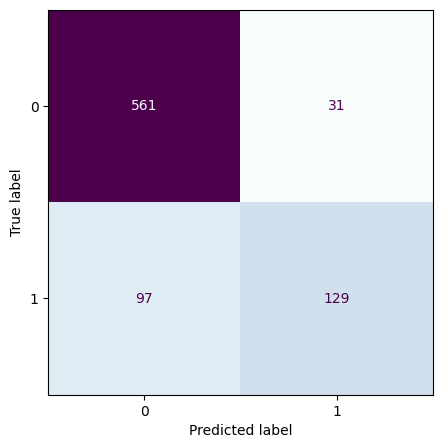

In [ ]:
cm = confusion_matrix(y_test, pred)
cmd = ConfusionMatrixDisplay(cm)

fig, ax = plt.subplots(figsize=(5, 5))
cmd.plot(ax=ax,  cmap = 'BuPu', colorbar = False)

ROC AUC Curve

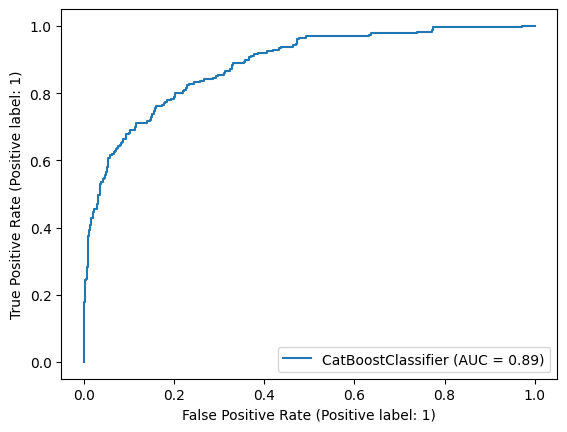

In [ ]:
RocCurveDisplay.from_estimator(model, X_test, y_test)

Conformal Prediction

In [ ]:
# calibrating data for the conformal prediction

# original code from -> https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration_curve.html

cat_isotonic = CalibratedClassifierCV(model, cv = 8, method="isotonic")
cat_sigmoid = CalibratedClassifierCV(model, cv = 8, method="sigmoid")

clf_list = [
    (model, "CatBoost"),
    (cat_isotonic, "CatBoost + Isotonic"),
    (cat_sigmoid, "CatBoost + Sigmoid")]

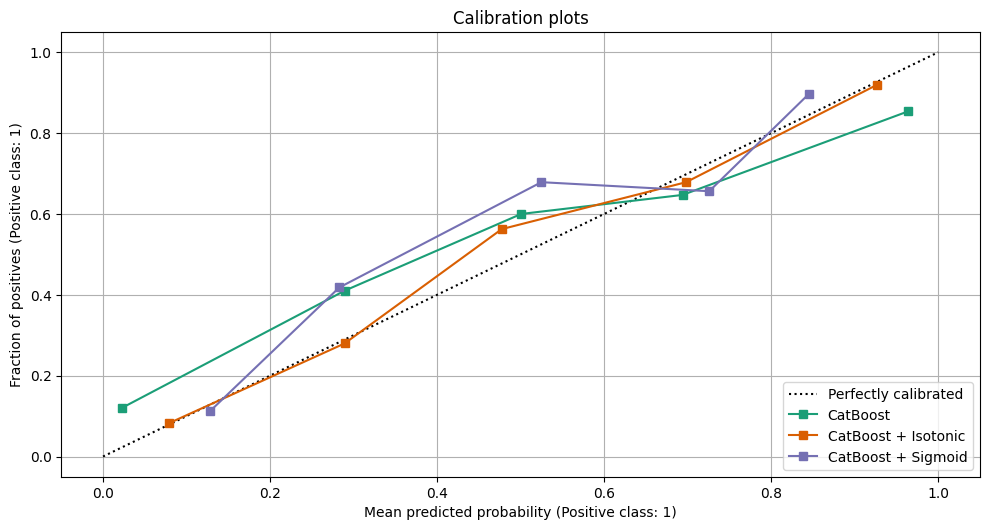

In [ ]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)

    display = CalibrationDisplay.from_estimator( clf, X_test, y_test, n_bins=5, name=name,
        ax=ax_calibration_curve, color=colors(i) )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots")


plt.tight_layout()
plt.show()

Prediction Isotonic CalibratedClassifierCV

In [ ]:
# Isotonic method is gained a small improvement in our predictions

iso_pred = cat_isotonic.predict(X_test)
mse = mean_squared_error(y_test, iso_pred)
acc = accuracy_score(y_test, iso_pred)

print('Mean Squared Error : {0:.5f}'.format(mse))
print('Accuracy Score : {0:.2f} %'.format(acc*100))

Mean Squared Error : 0.15281
Accuracy Score : 84.72 %


CalibratedClassifierCV Classification Report

In [ ]:
# classification report

clf_report = classification_report(y_test, iso_pred)
print(clf_report)

              precision    recall  f1-score   support

           0       0.85      0.95      0.90       592
           1       0.83      0.57      0.67       226

    accuracy                           0.85       818
   macro avg       0.84      0.76      0.79       818
weighted avg       0.84      0.85      0.84       818



CalibratedClassifierCV Confusion Matrix

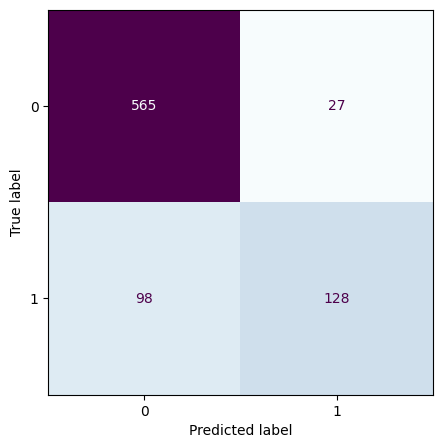

In [ ]:
cm = confusion_matrix(y_test, iso_pred)
cmd = ConfusionMatrixDisplay(cm)

fig, ax = plt.subplots(figsize=(5, 5))
cmd.plot(ax=ax,  cmap = 'BuPu', colorbar = False)

CalibratedClassifierCV ROC AUC Curve

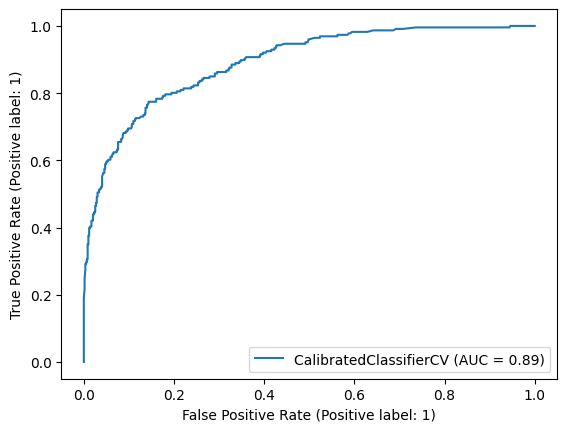

In [ ]:
RocCurveDisplay.from_estimator(cat_isotonic, X_test, y_test)

Another model

Data Analysis

In [ ]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor, VotingClassifier,VotingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score,mean_squared_error
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import sklearn.metrics as metrics
import seaborn as sn


In [6]:
import seaborn as sns

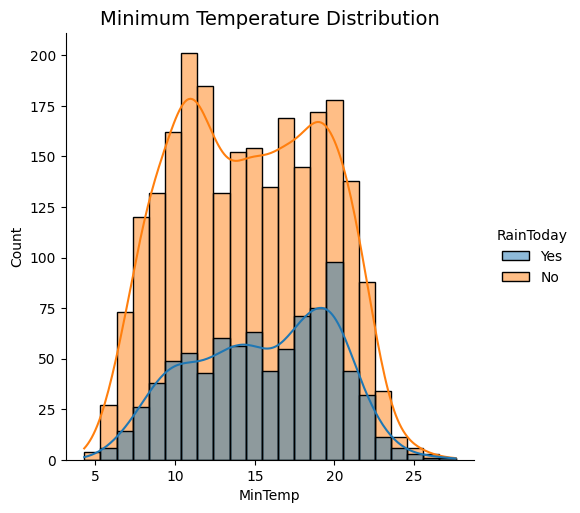

In [7]:
sns.displot(data, x="MinTemp", hue='RainToday', kde=True)
plt.title("Minimum Temperature Distribution", fontsize = 14)
plt.show()

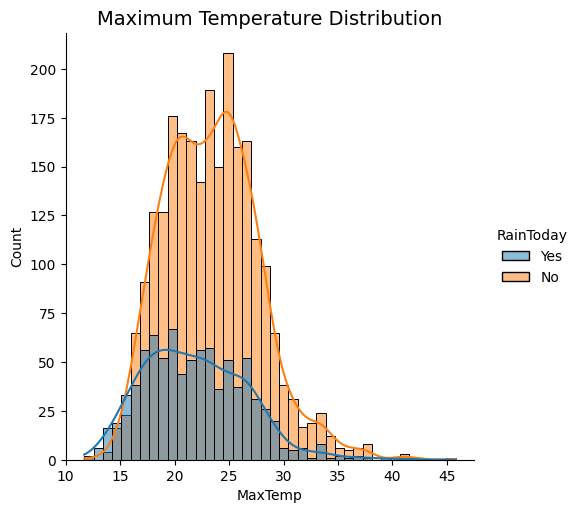

In [8]:
sns.displot(data, x="MaxTemp", hue='RainToday', kde=True)
plt.title("Maximum Temperature Distribution", fontsize = 14)
plt.show()

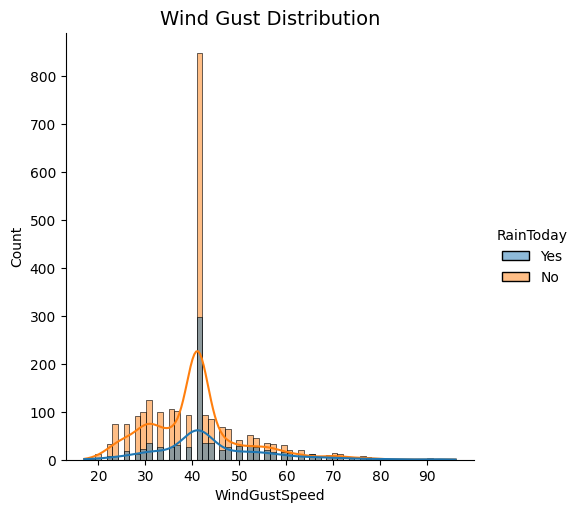

In [9]:
sns.displot(data, x="WindGustSpeed", hue='RainToday', kde=True)
plt.title("Wind Gust Distribution", fontsize = 14)
plt.show()

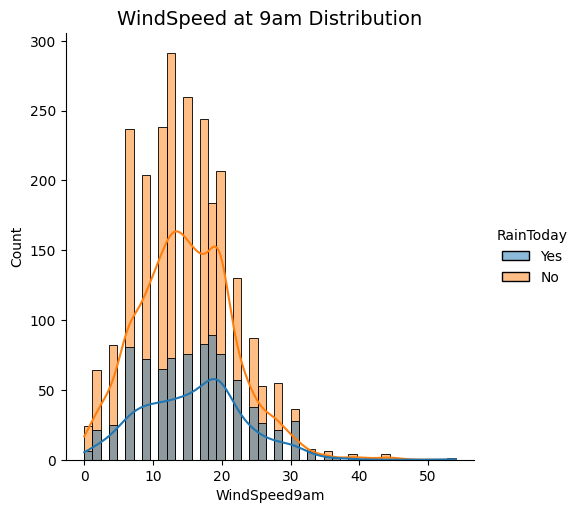

In [11]:
sns.displot(data, x="WindSpeed9am", hue='RainToday', kde=True)
plt.title("WindSpeed at 9am Distribution", fontsize = 14)
plt.show()

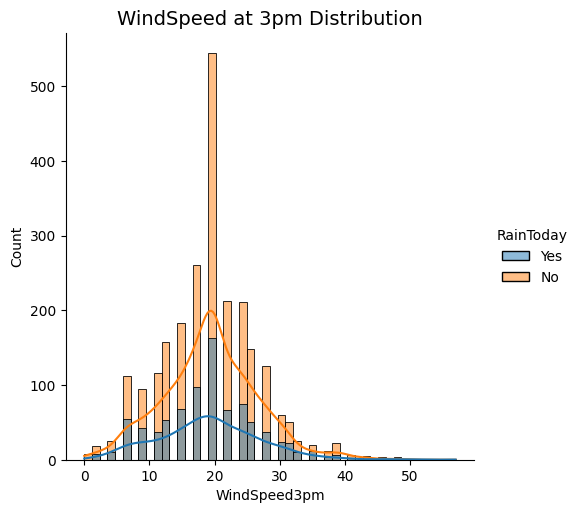

In [12]:
sns.displot(data, x="WindSpeed3pm", hue='RainToday', kde=True)
plt.title("WindSpeed at 3pm Distribution", fontsize = 14)
plt.show()

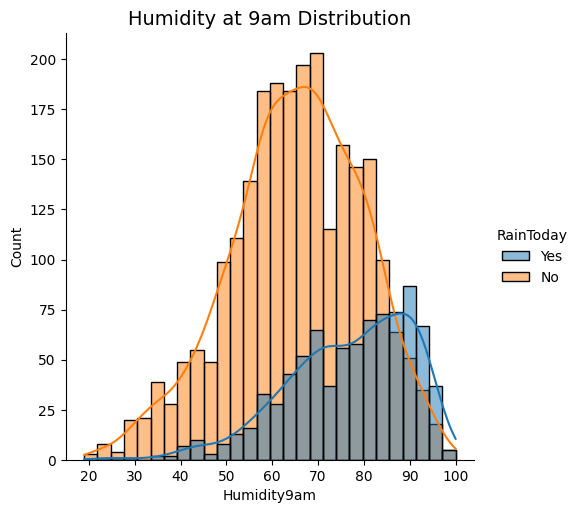

In [14]:
sns.displot(data, x="Humidity9am", hue='RainToday', kde=True)
plt.title("Humidity at 9am Distribution", fontsize = 14)
plt.show()

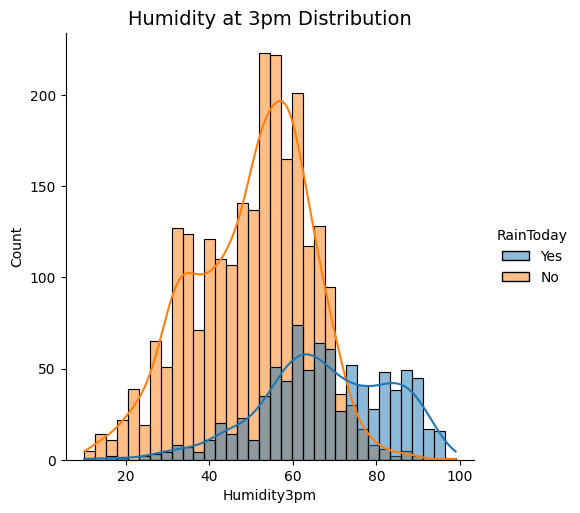

In [15]:
sns.displot(data, x="Humidity3pm", hue='RainToday', kde=True)
plt.title("Humidity at 3pm Distribution", fontsize = 14)
plt.show()

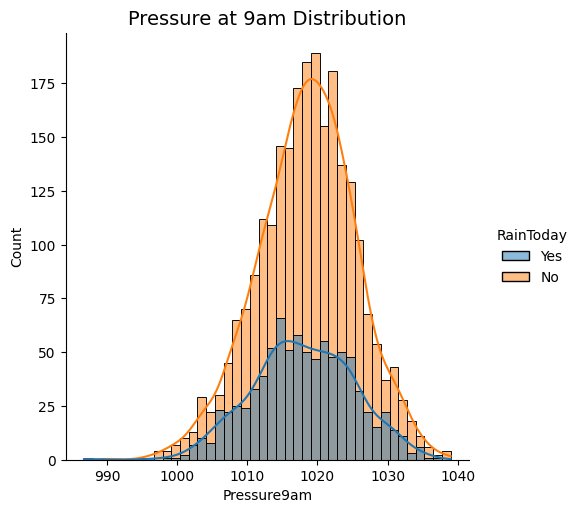

In [17]:
sns.displot(data, x="Pressure9am", hue='RainToday', kde=True)
plt.title("Pressure at 9am Distribution", fontsize = 14)
plt.show()

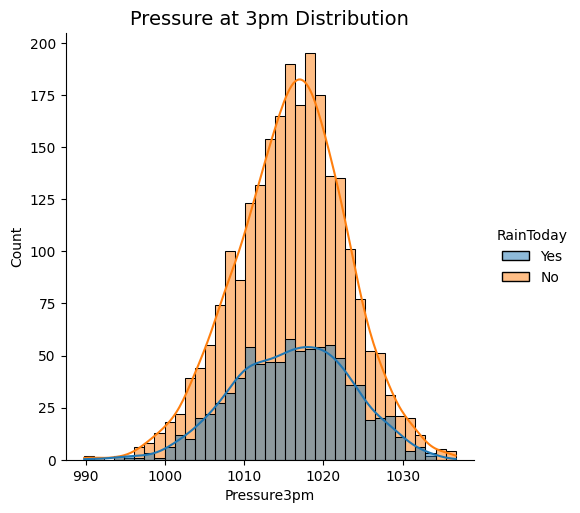

In [19]:
sns.displot(data, x="Pressure3pm", hue='RainToday', kde=True)
plt.title("Pressure at 3pm Distribution", fontsize = 14)
plt.show()

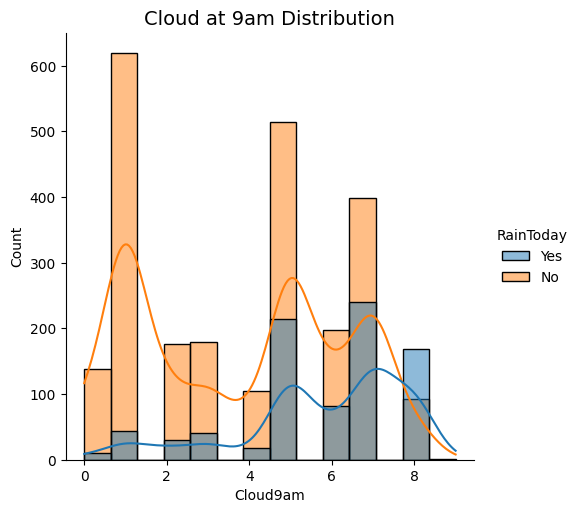

In [21]:
sns.displot(data, x="Cloud9am", hue='RainToday', kde=True)
plt.title("Cloud at 9am Distribution", fontsize = 14)
plt.show()

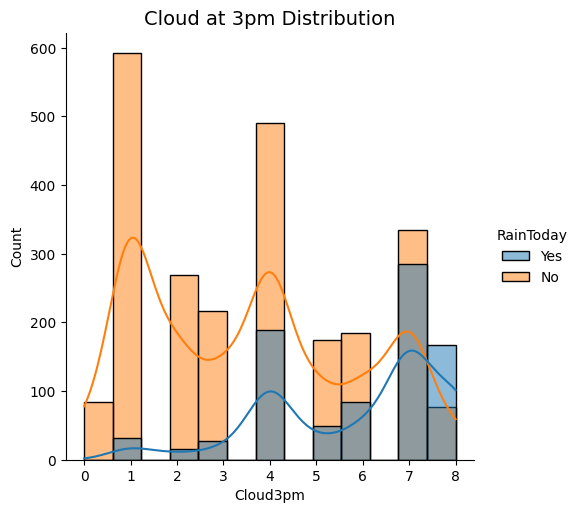

In [23]:
sns.displot(data, x="Cloud3pm", hue='RainToday', kde=True)
plt.title("Cloud at 3pm Distribution", fontsize = 14)
plt.show()

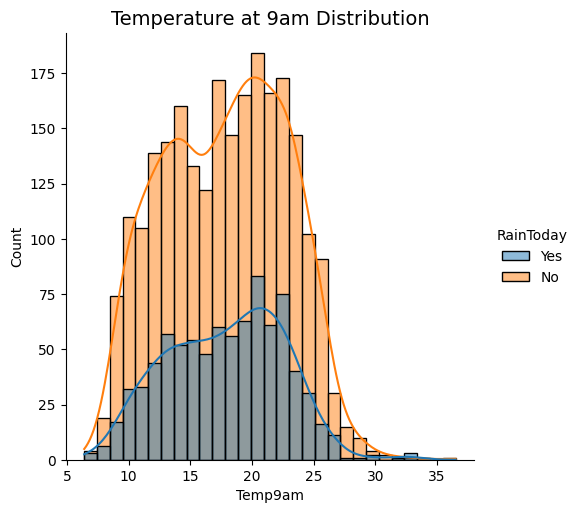

In [25]:
sns.displot(data, x="Temp9am", hue='RainToday', kde=True)
plt.title("Temperature at 9am Distribution", fontsize = 14)
plt.show()

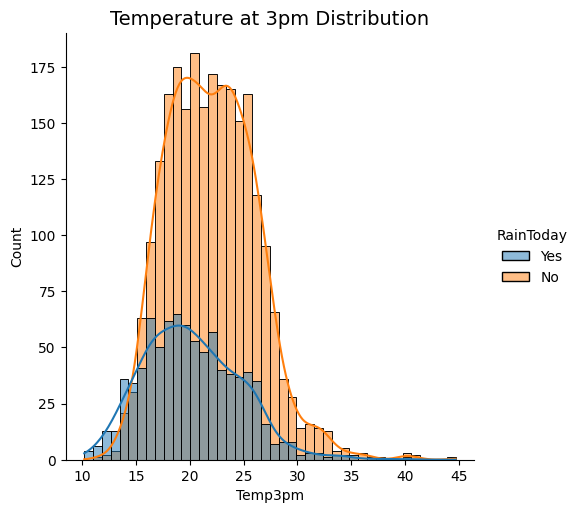

In [27]:
sns.displot(data, x="Temp3pm", hue='RainToday', kde=True)
plt.title("Temperature at 3pm Distribution", fontsize = 14)
plt.show()

# . EDA

# Average WindSpeed Analysis

In [44]:

windspeed_weather_data = data.groupby(data['Date'].str[3:5])[['WindSpeed9am', 'WindSpeed3pm']].mean()
windspeed_weather_data = windspeed_weather_data.reset_index()
windspeed_weather_data

,Date,WindSpeed9am,WindSpeed3pm
0,01,15.285171,17.403042
1,02,15.468504,18.228346
2,03,15.989247,18.053763
3,04,16.466667,19.396296
4,05,16.580645,18.419355
5,06,15.077778,18.807407
6,07,14.612903,20.229391
7,08,13.645161,20.114695
8,09,13.818519,21.203704
9,10,13.896057,21.007168


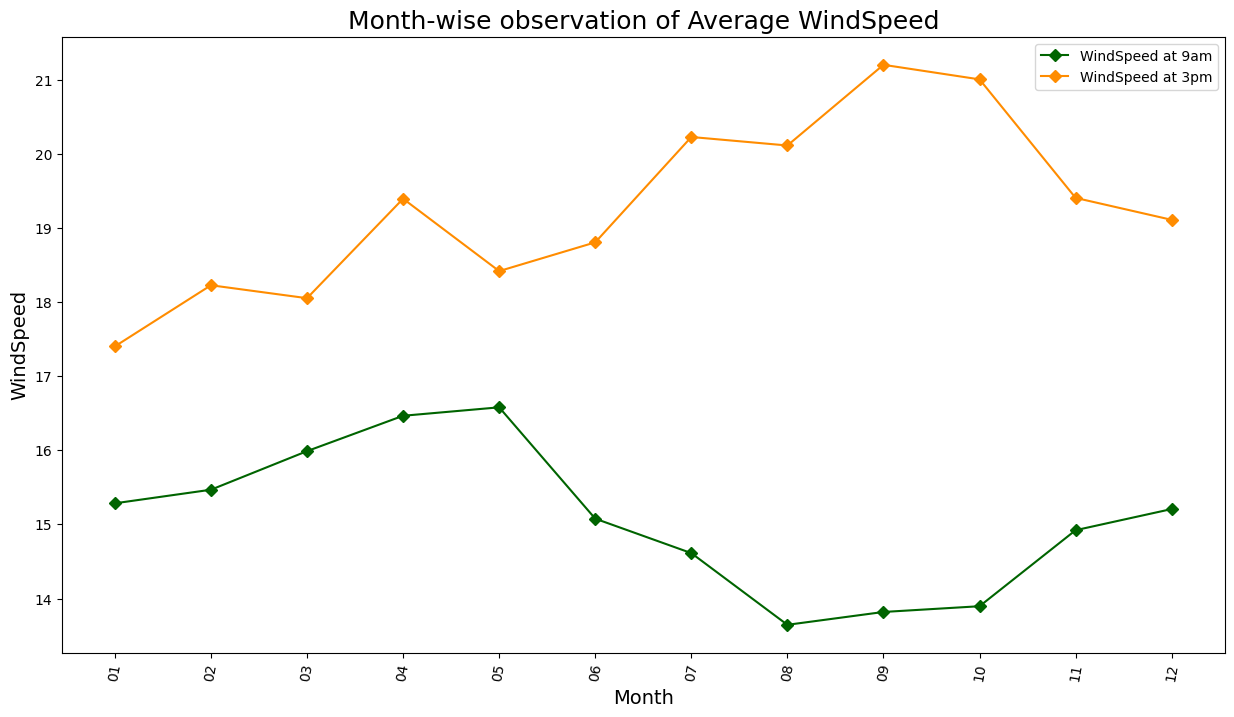

In [47]:
x = windspeed_weather_data.loc[:, 'Date']
y1 = windspeed_weather_data['WindSpeed9am']
y2 = windspeed_weather_data['WindSpeed3pm']

plt.figure(figsize = (15, 8))

plt.plot(x, y1, marker='D', color = 'darkgreen', label = 'WindSpeed at 9am')
plt.plot(x, y2, marker='D', color = 'darkorange', label = 'WindSpeed at 3pm')

plt.xlabel('Month', fontsize = 14)
plt.ylabel('WindSpeed', fontsize = 14)
plt.title('Month-wise observation of Average WindSpeed', fontsize = 18)
plt.legend(fontsize = 10, loc = 'best')
plt.xticks(rotation=80)
plt.show()

# Average Humidity Analysis

In [50]:
humidity_weather_data = data.groupby(data['Date'].str[3:5])[['Humidity9am', 'Humidity3pm']].mean()
humidity_weather_data= humidity_weather_data.reset_index()
humidity_weather_data

,Date,Humidity9am,Humidity3pm
0,01,73.574144,57.136882
1,02,72.830709,56.468504
2,03,68.519713,52.698925
3,04,67.285185,52.374074
4,05,64.014337,49.906810
5,06,66.433333,54.000000
6,07,65.179211,52.333333
7,08,64.164875,52.867384
8,09,65.844444,56.100000
9,10,71.197133,59.139785


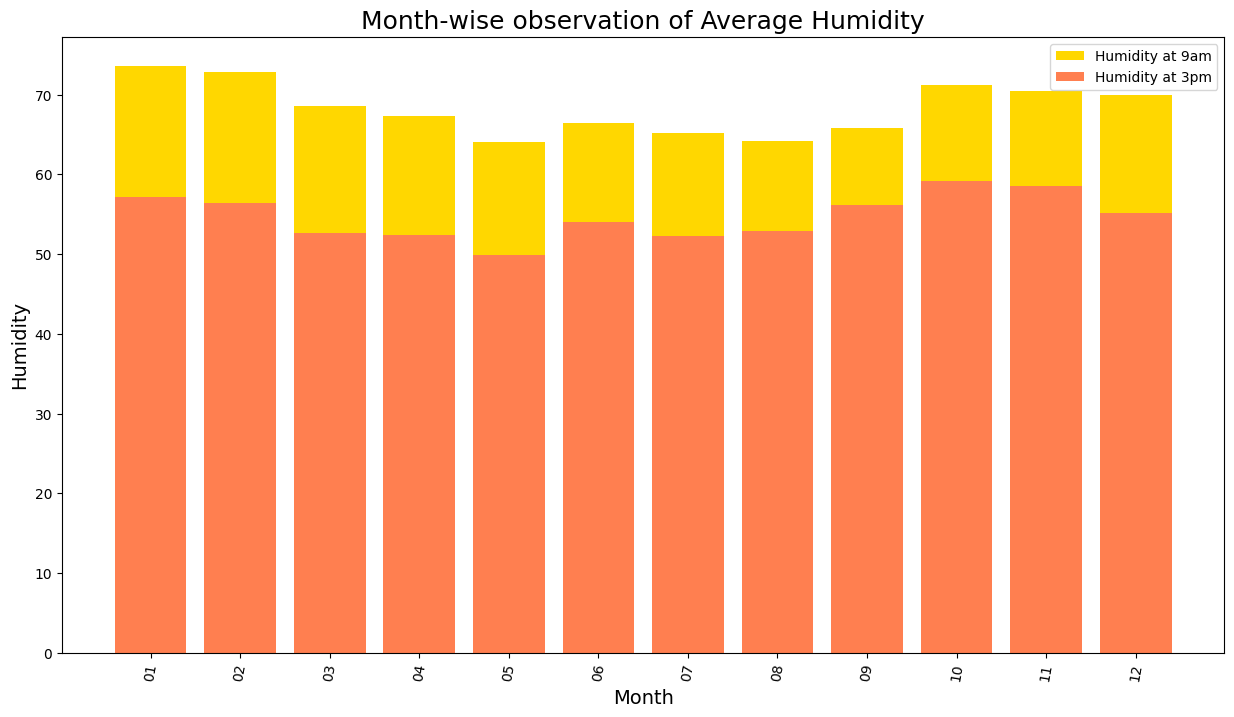

In [51]:
x = humidity_weather_data.loc[:, 'Date']
y1 = humidity_weather_data['Humidity9am']
y2 = humidity_weather_data['Humidity3pm']

plt.figure(figsize = (15, 8))

plt.bar(x, y1, color = 'gold', label = 'Humidity at 9am')
plt.bar(x, y2, color = 'coral',label = 'Humidity at 3pm')

plt.xlabel('Month', fontsize = 14)
plt.ylabel('Humidity', fontsize = 14)
plt.title('Month-wise observation of Average Humidity', fontsize = 18)
plt.legend(fontsize = 10, loc = 'best')
plt.xticks(rotation=80)
plt.show()

# Average Pressure Analysis

In [52]:
pressure_weather_data = data.groupby(data['Date'].str[3:5])[['Pressure9am', 'Pressure3pm']].mean()
pressure_weather_data = pressure_weather_data.reset_index()
pressure_weather_data

,Date,Pressure9am,Pressure3pm
0,01,1019.358175,1017.123574
1,02,1018.531496,1016.374803
2,03,1020.687097,1018.254122
3,04,1020.229630,1017.622222
4,05,1019.886738,1017.269391
5,06,1018.396667,1015.952593
6,07,1017.147670,1014.789964
7,08,1015.941577,1013.565789
8,09,1016.675556,1014.475100
9,10,1018.082079,1016.032258


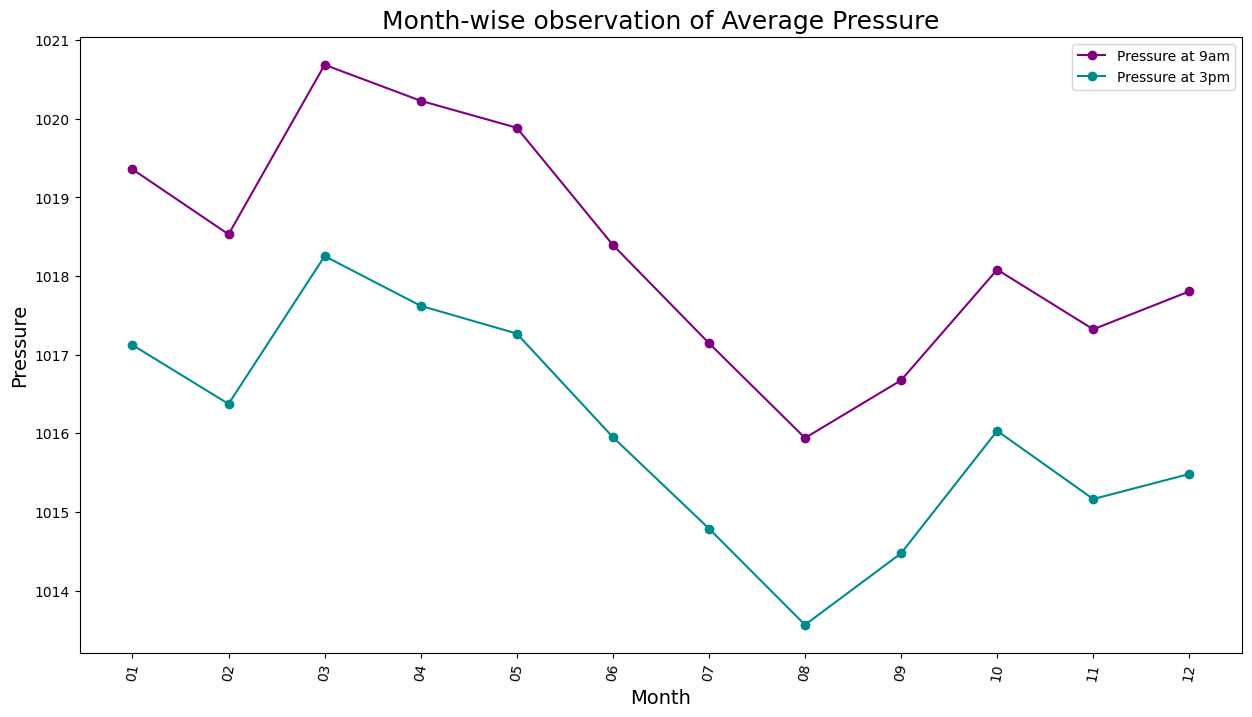

In [53]:
x = pressure_weather_data.loc[:, 'Date']
y1 = pressure_weather_data['Pressure9am']
y2 = pressure_weather_data['Pressure3pm']

plt.figure(figsize = (15, 8))

plt.plot(x, y1, marker='o', color = 'purple', label = 'Pressure at 9am')
plt.plot(x, y2, marker='o', color = 'darkcyan', label = 'Pressure at 3pm')

plt.xlabel('Month', fontsize = 14)
plt.ylabel('Pressure', fontsize = 14)
plt.title('Month-wise observation of Average Pressure', fontsize = 18)
plt.legend(fontsize = 10, loc = 'best')
plt.xticks(rotation=80)
plt.show()

# Average Temperature Analysis

In [55]:
location_weather_data = data.groupby(data['Date'].str[3:5])[['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']].mean()
location_weather_data = location_weather_data.reset_index()
location_weather_data

,Date,MinTemp,MaxTemp,Temp9am,Temp3pm
0,01,14.851331,22.621673,17.158555,21.422814
1,02,14.154331,21.984252,16.439764,20.783858
2,03,12.713620,21.339068,15.451971,20.127599
3,04,12.600000,21.145926,15.721111,19.736667
4,05,12.651971,21.878495,15.939785,20.335125
5,06,13.621852,22.000741,16.786296,20.429259
6,07,14.223297,22.521505,17.465591,20.882437
7,08,15.870251,24.025090,19.237276,22.390323
8,09,17.608148,25.315926,21.029630,23.648889
9,10,17.709319,24.853047,20.483154,23.400000


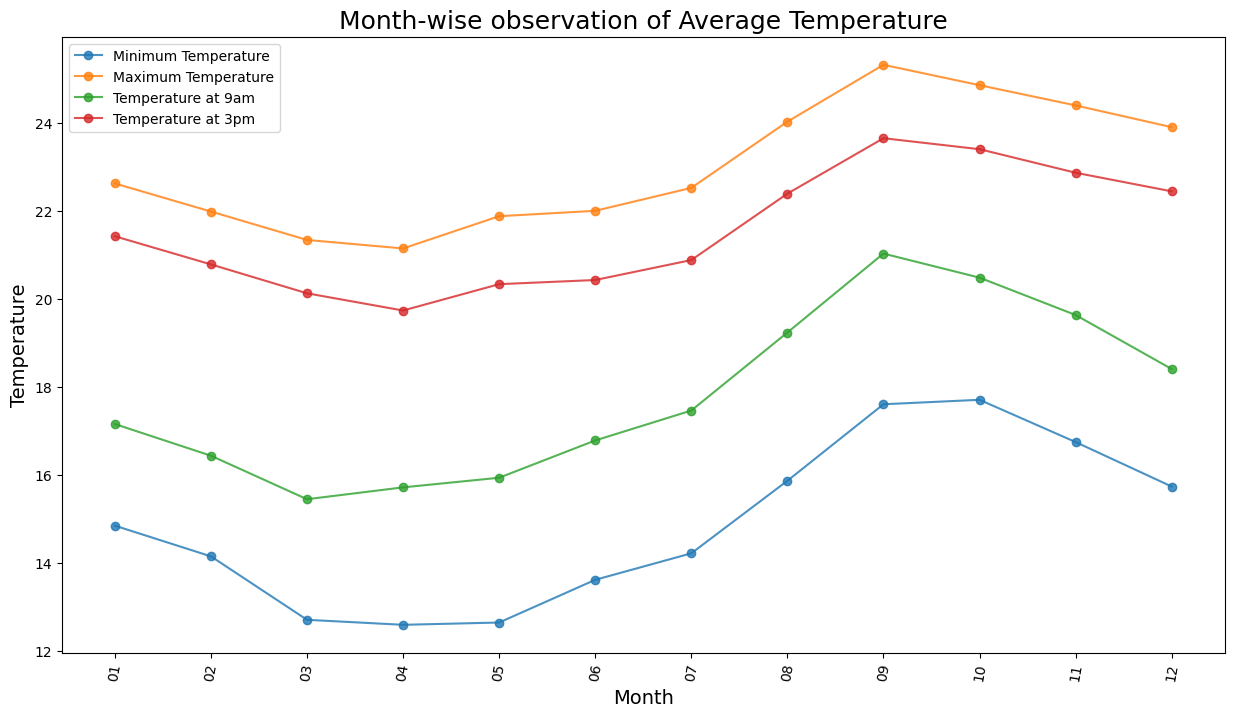

In [56]:
x = location_weather_data.loc[:, 'Date']
y1 = location_weather_data['MinTemp']
y2 = location_weather_data['MaxTemp']
y3 = location_weather_data['Temp9am']
y4 = location_weather_data['Temp3pm']

plt.figure(figsize = (15, 8))

plt.plot(x, y1, label = 'Minimum Temperature', marker='o', alpha = 0.8)
plt.plot(x, y2, label = 'Maximum Temperature', marker='o', alpha = 0.8)
plt.plot(x, y3, label = 'Temperature at 9am', marker='o', alpha = 0.8)
plt.plot(x, y4, label = 'Temperature at 3pm', marker='o', alpha = 0.8)

plt.xlabel('Month', fontsize = 14)
plt.ylabel('Temperature', fontsize = 14)
plt.title('Month-wise observation of Average Temperature', fontsize = 18)
plt.legend(fontsize = 10, loc = 'best')
plt.xticks(rotation=80)
plt.show()

# Correlation and Description of the data

In [59]:
data.describe()

,Temp9am,Temp3pm,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm
count,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000,3271.000000
mean,17.821461,21.543656,14.877102,23.005564,3.342158,5.175787,7.168970,41.476307,15.077041,19.294405,68.243962,54.698563,1018.334424,1016.003085,4.318557,4.176093
std,4.894316,4.297053,4.554710,4.483752,9.917746,2.757684,3.815966,10.806951,7.043825,7.453331,15.086127,16.279241,7.020090,7.019915,2.526923,2.411274
min,6.400000,10.200000,4.300000,11.700000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,19.000000,10.000000,986.700000,989.800000,0.000000,0.000000
25%,13.800000,18.400000,11.000000,19.600000,0.000000,3.200000,4.250000,35.000000,11.000000,15.000000,58.000000,44.000000,1013.700000,1011.300000,2.000000,2.000000
50%,18.200000,21.300000,14.900000,22.800000,0.000000,4.800000,8.300000,41.000000,15.000000,19.000000,69.000000,56.000000,1018.600000,1016.300000,5.000000,4.000000
75%,21.700000,24.500000,18.800000,26.000000,1.400000,7.000000,10.200000,44.000000,20.000000,24.000000,80.000000,64.000000,1023.100000,1020.800000,7.000000,7.000000
max,36.500000,44.700000,27.600000,45.800000,119.400000,18.400000,13.600000,96.000000,54.000000,57.000000,100.000000,99.000000,1039.000000,1036.700000,9.000000,8.000000


In [60]:
bf=data.drop(columns=['Date','RainToday','WindGustDir', 'WindDir9am', 'WindDir3pm'])

In [61]:
bf.corr()

,Temp9am,Temp3pm,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm
Temp9am,1.000000,0.828457,0.939307,0.858639,-0.054297,0.606122,0.113891,0.159570,-0.334084,0.280009,-0.145944,0.131855,-0.417437,-0.401353,0.093204,0.068683
Temp3pm,0.828457,1.000000,0.753147,0.960805,-0.142748,0.474599,0.345528,0.036216,-0.351836,0.136713,-0.155192,-0.212696,-0.342862,-0.387945,-0.086544,-0.144965
MinTemp,0.939307,0.753147,1.000000,0.771005,0.013995,0.569316,-0.063475,0.127792,-0.298040,0.225905,0.053946,0.273269,-0.391654,-0.353334,0.241248,0.164028
MaxTemp,0.858639,0.960805,0.771005,1.000000,-0.139306,0.510334,0.327422,0.073184,-0.349382,0.155542,-0.185382,-0.150741,-0.385853,-0.420375,-0.084695,-0.099217
Rainfall,-0.054297,-0.142748,0.013995,-0.139306,1.000000,-0.110343,-0.308962,0.149811,0.153696,0.039415,0.332636,0.305635,-0.037561,0.001780,0.245231,0.200999
Evaporation,0.606122,0.474599,0.569316,0.510334,-0.110343,1.000000,0.175932,0.245426,-0.077532,0.292469,-0.395651,-0.102295,-0.343581,-0.298303,-0.037051,-0.038422
Sunshine,0.113891,0.345528,-0.063475,0.327422,-0.308962,0.175932,1.000000,-0.029032,-0.058410,0.177813,-0.490631,-0.586476,-0.047789,-0.094507,-0.665014,-0.677861
WindGustSpeed,0.159570,0.036216,0.127792,0.073184,0.149811,0.245426,-0.029032,1.000000,0.256460,0.509825,-0.225613,-0.095037,-0.408876,-0.351850,0.024275,0.044016
WindSpeed9am,-0.334084,-0.351836,-0.298040,-0.349382,0.153696,-0.077532,-0.058410,0.256460,1.000000,0.197669,-0.189763,-0.148849,0.003737,0.091878,-0.062441,-0.018030
WindSpeed3pm,0.280009,0.136713,0.225905,0.155542,0.039415,0.292469,0.177813,0.509825,0.197669,1.000000,-0.288910,-0.135039,-0.333810,-0.277749,-0.050932,-0.095435


<Axes: >

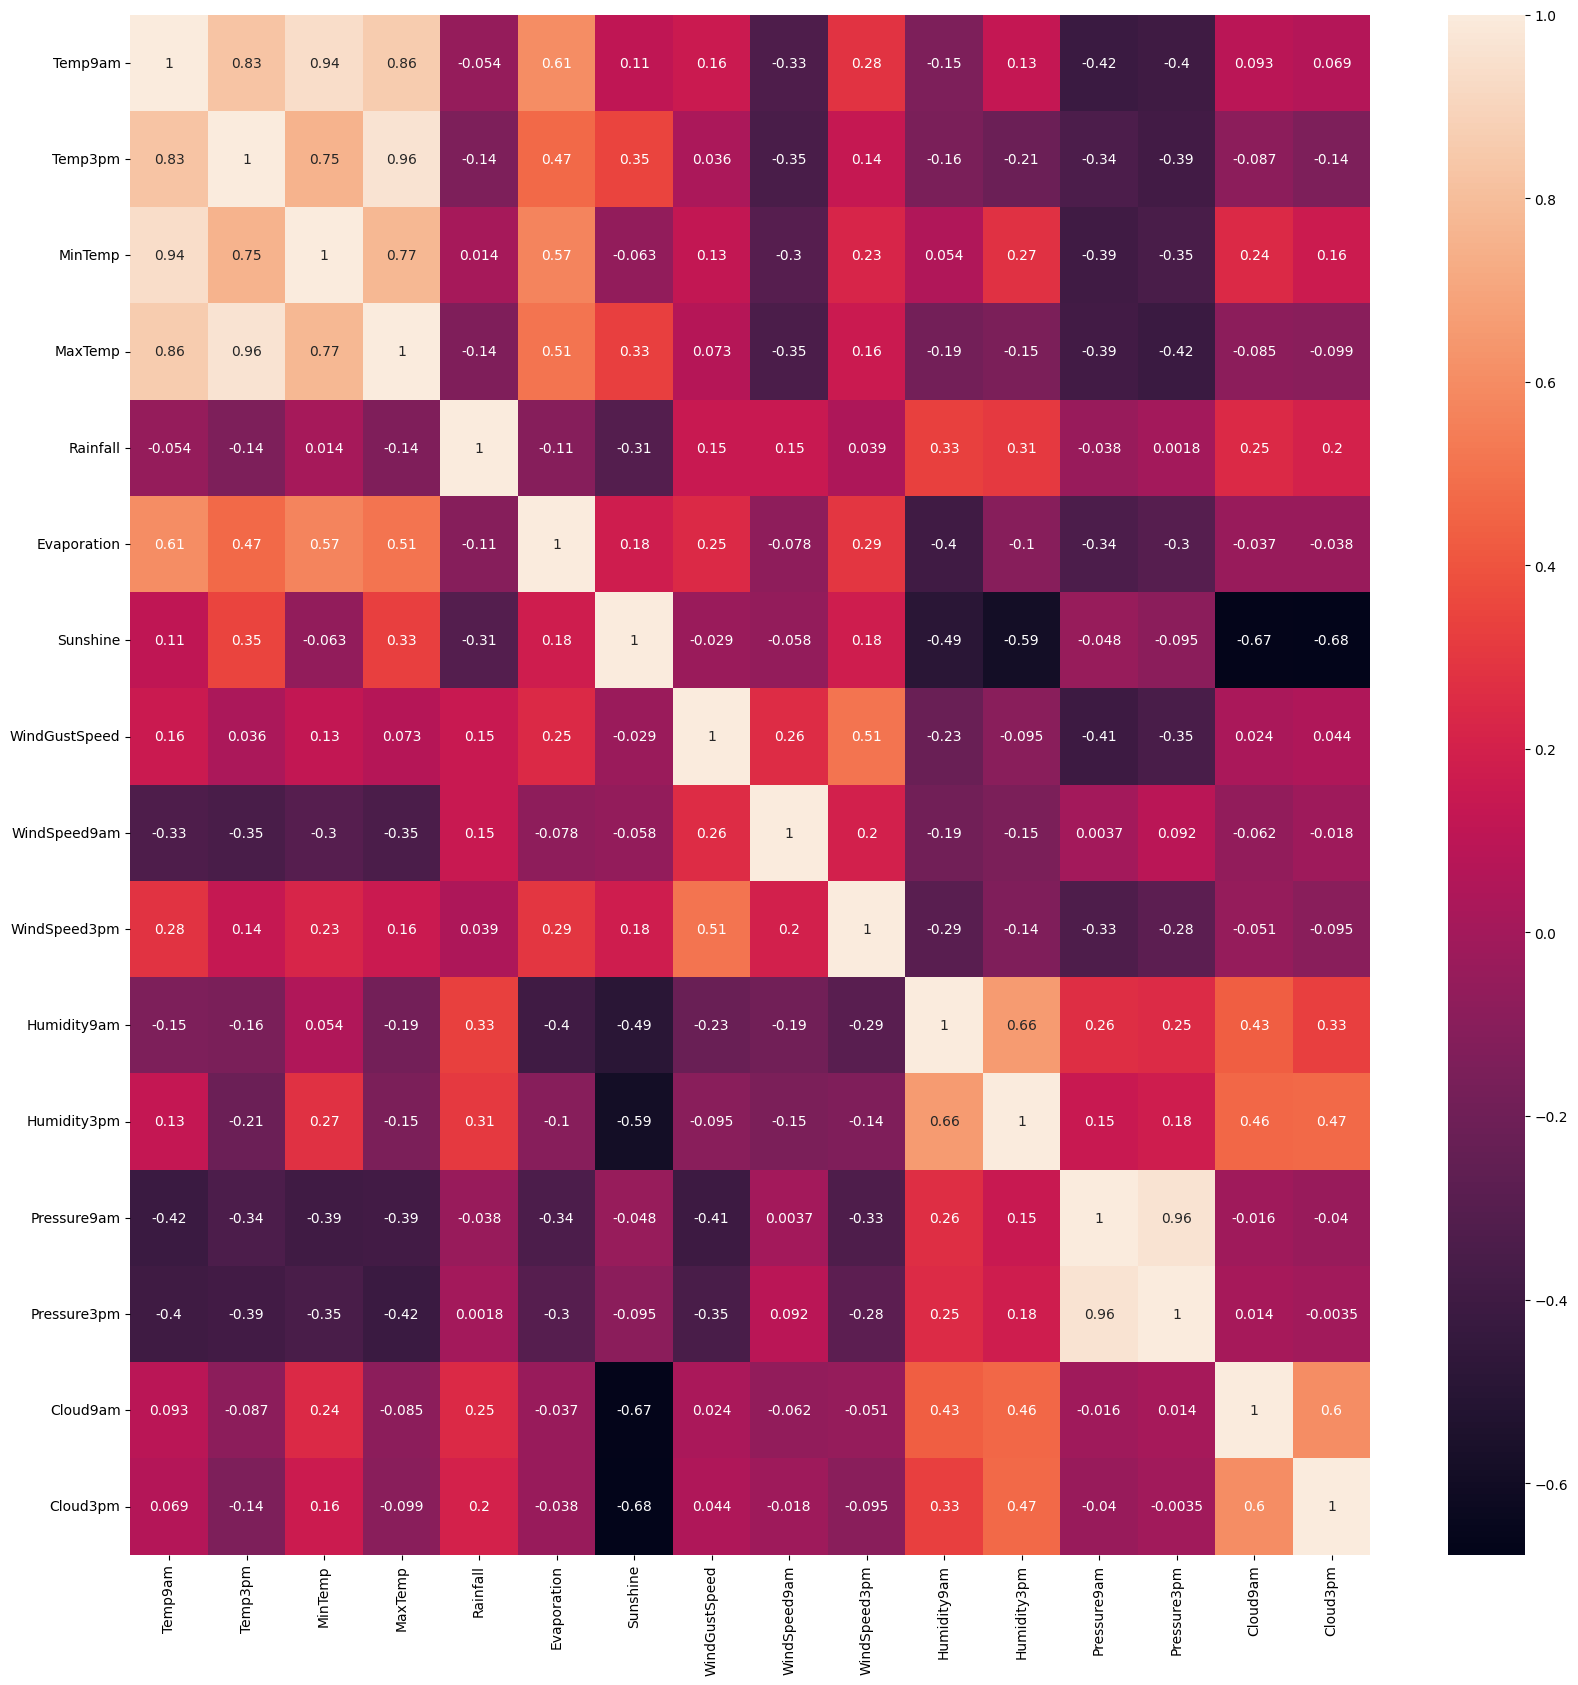

In [62]:
plt.figure(figsize=(20, 20))
sns.heatmap(bf.corr(), annot=True)